In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "30"

import sys
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.ert as ert

import statsmodels

import complex_inversion_tools as cit

import matplotlib.transforms as mtransforms

(<Axes: >, None)

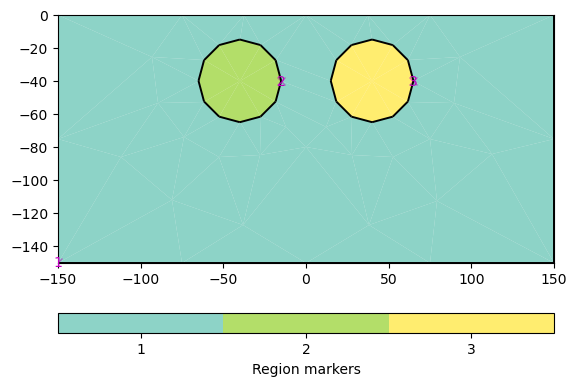

In [2]:
# creating the geometry to simulate the synthetic measurements

world = mt.createWorld(start=(-150, 0), end=(150, -150), marker=1)
circle = mt.createCircle(pos=(-40, -40), radius=25, marker=2, boundaryMarker=-1)
circle2 = mt.createCircle(pos=(40, -40), radius=25, marker=3, boundaryMarker=-1)
geom = world + circle + circle2

pg.show(geom)

In [3]:
# creating the measurements scheme

elecs = np.linspace(-100, 100, 50)
scheme = ert.createERTData(elecs, schemeName="dd")

24/07/24 - 10:15:10 - pyGIMLi - WARNING - createERTData had been renamed to createData and will be removed in: 1.3


In [4]:
# defining the complex resistivities of the subsurface model

rhomap = [
    [1, np.exp(2 - 20j / 1000)],
    [2, np.exp(1 - 15j / 1000)],
    [3, np.exp(3 - 60j / 1000)]
]

In [5]:
for s in scheme.sensors():
    geom.createNode(s)
    world.createNode(s)

INFO:pyGIMLi:Cache /home/hase/anaconda3/envs/tfpygimli/lib/python3.10/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (72.1s x 298): /home/hase/.cache/pygimli/1182362788374685924


24/07/24 - 10:15:11 - pyGIMLi - INFO - Cache /home/hase/anaconda3/envs/tfpygimli/lib/python3.10/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (72.1s x 298): /home/hase/.cache/pygimli/1182362788374685924


INFO:pyGIMLi:Cache /home/hase/anaconda3/envs/tfpygimli/lib/python3.10/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (72.1s x 299): /home/hase/.cache/pygimli/1182362788374685924


24/07/24 - 10:15:11 - pyGIMLi - INFO - Cache /home/hase/anaconda3/envs/tfpygimli/lib/python3.10/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (72.1s x 299): /home/hase/.cache/pygimli/1182362788374685924


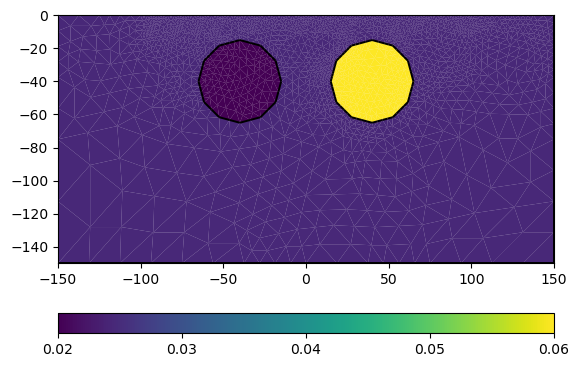

In [6]:
# creating the mesh used for the simulation of the synthetic data

mesh_fwd = pg.meshtools.createMesh(geom, quality=34.5).createH2()
true_conductivity = np.log(1 / pg.solver.parseMapToCellArray(rhomap, mesh_fwd))
pg.show(mesh_fwd, true_conductivity.imag)

geom_factors = ert.createGeometricFactors(scheme, mesh=mesh_fwd)

scheme.add("k", ert.createGeometricFactors(scheme, mesh=mesh_fwd))

In [7]:
geom_factors = np.array(geom_factors)

In [8]:
# simulating the synthetic measurements

ERT = pg.physics.ert.ERTManager(verbose=True, sr=0)
ERT.fop.setComplex(True)
data = ERT.simulate(mesh_fwd, scheme=scheme, res=rhomap, noiseLevel=0.0)

ModellingBase::setMesh() copying new mesh ... Found topography for surface=-50.9375 : -47.8125
INFO:pyGIMLi:Complex resistivity values found.
Found datafile: 50 electrodes
Found: 50 free-electrodes
rMin = 2.04082, rMax = 400
NGauLeg + NGauLag for inverse Fouriertransformation: 13 + 4
Found non-Neumann domain
0.010926 s
FOP updating mesh dependencies ... 2.91e-06 s


24/07/24 - 10:15:11 - pyGIMLi - INFO - Complex resistivity values found.


Calculating response for model: min = (2.71798,-0.0407727) max = (20.0494,-1.20441)
Forward: time: 0.752168s


(<Axes: >, None)

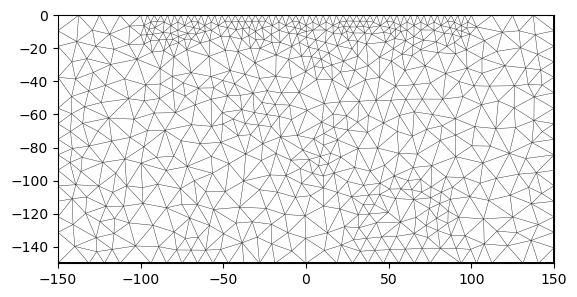

In [9]:
# creating a second mesh for the inversion to avoid inverse crimes

mesh_inv_inner = pg.meshtools.createMesh(world, quality=34.5, area=100)
pg.show(mesh_inv_inner, markers=False)

(<Axes: >, None)

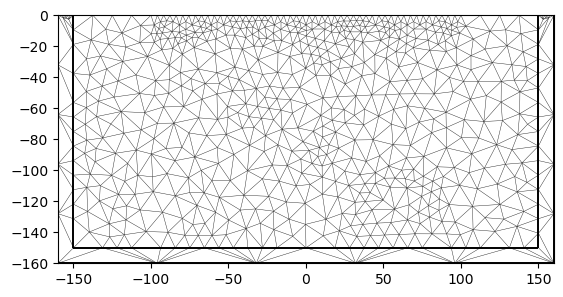

In [10]:
mesh_inv = pg.meshtools.appendTriangleBoundary(mesh_inv_inner, marker=0)
pg.show(mesh_inv, markers=False)

In [11]:
# setting up the forward operator for the inversion

ERTinv = pg.physics.ert.ERTManager(data=data)
ERTinv.applyMesh(mesh_inv)

INFO:pyGIMLi:Found 2 regions.


24/07/24 - 10:15:12 - pyGIMLi - INFO - Found 2 regions.


INFO:pyGIMLi:(ERTModelling) Region with smallest marker (0) set to background.


24/07/24 - 10:15:12 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (0) set to background.


In [12]:
# setting up the forward operator for the inversion

fop = pg.physics.ert.ERTModelling(sr=0, verbose=True)
fop.setComplex(True)
fop.setData(data)
fop.setMesh(ERTinv.paraDomain, ignoreRegionManager=True)

# defining dimensions of model and data space
M = ERTinv.paraDomain.cellCount()
D = len(data["rhoa"])

INFO:pyGIMLi:Creating forward mesh from region infos.


24/07/24 - 10:15:12 - pyGIMLi - INFO - Creating forward mesh from region infos.


INFO:pyGIMLi:Creating refined mesh (H2) to solve forward task.


24/07/24 - 10:15:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


INFO:pyGIMLi:Mesh for forward task: Mesh: Nodes: 2609 Cells: 5048 Boundaries: 3870


24/07/24 - 10:15:12 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2609 Cells: 5048 Boundaries: 3870


ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 50 electrodes
Found: 50 free-electrodes
rMin = 2.04082, rMax = 400
NGauLeg + NGauLag for inverse Fouriertransformation: 13 + 4
Found non-Neumann domain
0.0012353 s
FOP updating mesh dependencies ... 2.02e-06 s


In [13]:
# setting up the regularization operator(s)

rm = fop.regionManager()
rm.setVerbose(True)
rm.setConstraintType(2)
rm.setMesh(ERTinv.paraDomain)

Wm = pg.matrix.SparseMapMatrix()
rm.fillConstraints(Wm)
Wm = pg.utils.sparseMatrix2coo(Wm)

C_M_inv = (Wm.T @ Wm).toarray()

Reset region parameter
INFO:Core:More than 50 regions, so we assume single regions only.
RegionManager copying mesh ...0.00114454 s 
create NeighborInfos ... 0.00371903 s 
analysing mesh ... 1170 regions.


24/07/24 - 10:15:12 - Core - INFO - More than 50 regions, so we assume single regions only.


INFO:Core:Applying *:* interregion constraints.


24/07/24 - 10:15:12 - Core - INFO - Applying *:* interregion constraints.


creating para domain ... 0.00195169 s
Creating inter region constraints.


In [14]:
rhoa_complex = pg.utils.toComplex(data["rhoa"], data["phia"])
log_measurements = np.log(rhoa_complex**-1)

Z_complex = np.exp(-log_measurements) / geom_factors

In [15]:
# definition of the error models for impedance magnitude and phase

def error_model_lnmag(x, a, b):
    
    lin = np.abs(x) * a + b
    
    return lin / np.abs(x)

def error_model_phase(x, a, b, c):
    return a * np.abs(x) ** b + c

In [16]:
# synthetic noise

np.random.seed(42)

std_real = error_model_lnmag(np.abs(Z_complex), 1e-1, 1e-6)
std_imag = error_model_phase(np.abs(Z_complex), 1e-7, -0.9, 1e-4)

noise_real = - np.random.normal(loc=0, scale=std_real) / np.abs(rhoa_complex)
noise_imag = np.random.normal(loc=0, scale=std_imag)
noise_complex = noise_real + 1j * noise_imag
log_measurements = log_measurements + noise_complex

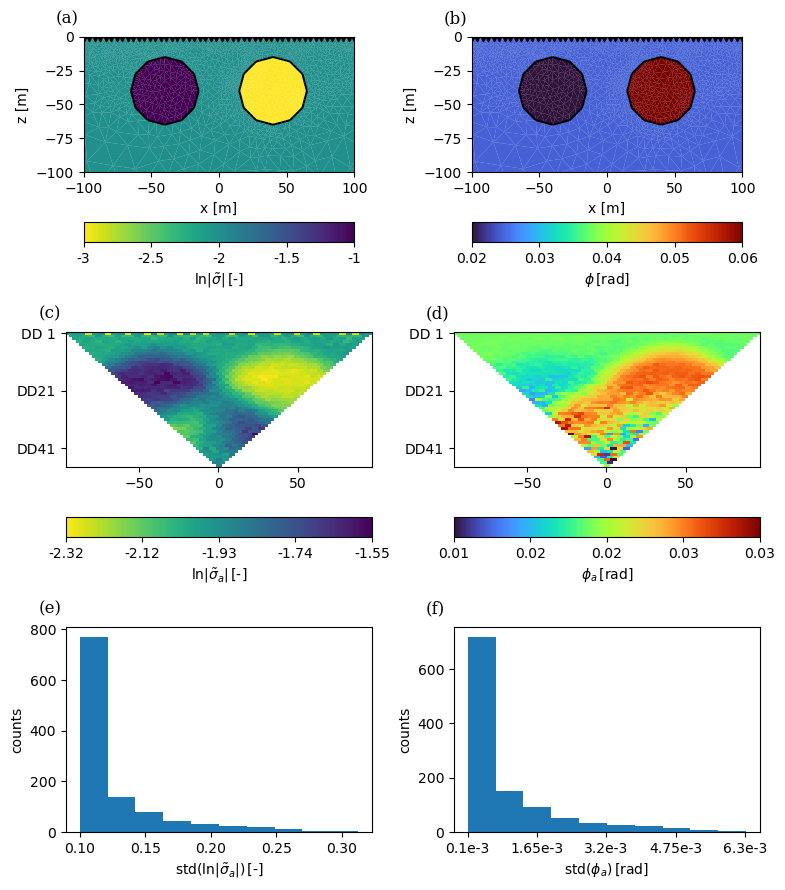

In [17]:
electrode_positions = np.array(scheme.sensorPositions())[:, 0:2]

fig, axes = plt.subplot_mosaic([["(a)", "(b)"], ["(c)", "(d)"], ["(e)", "(f)"]], figsize=(8, 9))

ax = axes["(a)"]
ax.set_title(" ")
pg.show(mesh_fwd, true_conductivity.real, ax=ax, label=r"$\ln|\tilde{\sigma}|\,$[-]", logScale=0, cMap="viridis_r", showBoundary=True)

ax = axes["(b)"]
pg.show(mesh_fwd, (true_conductivity).imag, ax=ax, label=r"$\phi\,$[rad]", logScale=0, cMap="turbo", showBoundary=True)

for iax in ["(a)", "(b)"]:
    ax = axes[iax]
    ax.scatter(electrode_positions[:, 0], electrode_positions[:, 1], marker="v", color="k")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("z [m]")
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 0)
    
    label = iax
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize='large', va='bottom', fontfamily='serif')

ax = axes["(c)"]
ax.set_title(" ")
ert.showERTData(data, log_measurements.real, ax=ax, label=r"$\ln|\tilde{\sigma}_a|\,$[-]", cMap="viridis_r", logScale=False)

ax = axes["(d)"]
ax.set_title(" ")
ert.showERTData(data, log_measurements.imag, ax=ax, label=r"$\phi_a\,$[rad]", cMap="turbo", logScale=False)

ax = axes["(e)"]
ax.set_title(" ")
ax.set_ylabel("counts")
ax.set_xlabel(r"std$(\ln|\tilde{\sigma}_a|)\,$[-]")
ax.hist(std_real)

ax = axes["(f)"]
ax.set_title(" ")
ax.set_ylabel("counts")
ax.set_xlabel(r"std$(\phi_a)\,$[rad]")
ax.hist(std_imag)
ax.set_xticks(np.linspace(np.round(np.min(std_imag), 4), np.round(np.max(std_imag), 4), 5))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.xaxis.set_major_formatter(lambda x, pos: str(np.round(x, 5) * 1e3) + "e-3") 

for iax in ["(c)", "(d)", "(e)", "(f)"]:
    
    ax = axes[iax]
    
    label = iax
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize='large', va='bottom', fontfamily='serif')

fig.tight_layout()

# fig.savefig("Figure1.pdf", bbox_inches="tight")

In [18]:
# Inversion using the full capabilities of the probabilistic framework

m = np.ones(2 * M) * (-1 + 1e-2j)
m[M:] = m[:M].conj()

mp = np.zeros_like(m)

d = np.hstack([log_measurements, log_measurements.conj()]).flatten()

def solve_forward_problem(m):
    
    rho = np.exp(-m[:M])

    response = pg.utils.toComplex(np.array(
        fop.response(np.array(pg.utils.squeezeComplex(rho)))))
    response = np.log(response**-1)
    
    J = fop.createJacobian(pg.utils.squeezeComplex(rho))
    J = np.array(J.mat(0)) + 1j * np.array(J.mat(1))
    J = np.multiply(J.T, -response**-2).T
    J = np.multiply(J, - rho)
    
    return np.hstack([response, response.conj()]).flatten(), J
    

# definition of the data covariance matrix with independent error estimates for impedance magnitude and phase
V_Re = np.diag(std_real ** 2)
V_Im = np.diag(std_imag ** 2)

Rd = np.vstack((
    np.hstack((V_Re + V_Im, V_Re - V_Im)),
    np.hstack(((V_Re - V_Im).conj().T, (V_Re + V_Im).conj()))
))
Rd = np.linalg.inv(Rd)

# definition of the inverse prior covariance matrix, using regularization
#     operators that are independently scaled with alpha, beta (corresponding to lamda_real, lambda_imag in the paper)
alpha = np.exp(6.3)
beta = np.exp(11)

VM_on = C_M_inv * (alpha + beta)
VM_off = C_M_inv * (alpha - beta)

Rm = np.vstack((
    np.hstack((VM_on, VM_off)),
    np.hstack((VM_off.conj().T, VM_on))
))

# for inversion details look at the definition of the Complex_Inversion_Manager in library.py
ciManager = cit.Complex_Inversion_Manager(m, d, solve_forward_problem, 1, Rd, Rm, mp)
ciManager.invVr = np.linalg.inv(V_Re)
ciManager.invVi = np.linalg.inv(V_Im)

ciManager.inversion(N_iterations=30, perform_line_search=0, ignore_cost_increase=1)

m_plot = ciManager.m[:M]

# using final model to calculate covariance
rmse = ciManager.rmse(ciManager.d, ciManager.solve_forward_problem(ciManager.m)[0])
COV = np.linalg.inv(ciManager.Jc.conj().T @ ciManager.Rd @ ciManager.Jc + ciManager.lam * ciManager.Rm)

INFO:pyGIMLi:Creating forward mesh from region infos.


24/07/24 - 10:15:15 - pyGIMLi - INFO - Creating forward mesh from region infos.


INFO:pyGIMLi:Creating refined mesh (H2) to solve forward task.


24/07/24 - 10:15:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


INFO:pyGIMLi:Mesh for forward task: Mesh: Nodes: 2453 Cells: 4680 Boundaries: 3622


24/07/24 - 10:15:15 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2453 Cells: 4680 Boundaries: 3622


ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 50 electrodes
Found: 50 free-electrodes
Found non-Neumann domain
0.0116079 s
FOP updating mesh dependencies ... 1.327e-05 s
Calculating response for model: min = (2.71815,-0.0271824) max = (2.71815,-0.0271824)
Forward: time: 1.1072s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.0139586:time: 0.338405s
39.385381779792446 9.118482731702954 54.947883203561396
INFO:root:
####################
Main iteration 0
####################


24/07/24 - 10:15:17 - root - INFO - 
####################
Main iteration 0
####################


Calculating response for model: min = (2.71815,-0.0271824) max = (2.71815,-0.0271824)
Forward: time: 0.925919s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.00208424:time: 0.326407s
rmse  (39.385381779792446, 9.118482731702954, 54.947883203561396)
INFO:root:
####################
Main iteration 1
####################


24/07/24 - 10:15:19 - root - INFO - 
####################
Main iteration 1
####################


Calculating response for model: min = (3.16874,-0.0439857) max = (4.60474,-0.136583)
Forward: time: 0.976167s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.00219317:time: 0.372582s
rmse  (12.956268003639819, 6.110103435748459, 17.274154021795805)
INFO:root:
####################
Main iteration 2
####################


24/07/24 - 10:15:22 - root - INFO - 
####################
Main iteration 2
####################


Calculating response for model: min = (4.03388,-0.0618507) max = (6.82263,-0.301666)
Forward: time: 1.40249s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.0027936:time: 0.295954s
rmse  (3.7036165337266542, 3.633098502494651, 3.7728167367331102)
INFO:root:
####################
Main iteration 3
####################


24/07/24 - 10:15:24 - root - INFO - 
####################
Main iteration 3
####################


Calculating response for model: min = (4.80527,-0.077384) max = (8.344,-0.376161)
Forward: time: 1.39124s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.00273676:time: 0.318257s
rmse  (4.591407009607473, 2.126323938410146, 6.13520848583831)
INFO:root:
####################
Main iteration 4
####################


24/07/24 - 10:15:27 - root - INFO - 
####################
Main iteration 4
####################


Calculating response for model: min = (5.26067,-0.0833159) max = (9.21857,-0.423428)
Forward: time: 1.39382s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.00276044:time: 0.307988s
rmse  (3.2131332390385015, 1.402982035368494, 4.322047180683414)
INFO:root:
####################
Main iteration 5
####################


24/07/24 - 10:15:30 - root - INFO - 
####################
Main iteration 5
####################


Calculating response for model: min = (5.50937,-0.0854792) max = (9.6735,-0.410835)
Forward: time: 1.39975s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.00281049:time: 0.314987s
rmse  (1.957247560149107, 1.1387495198866013, 2.5228724807987457)
INFO:root:
####################
Main iteration 6
####################


24/07/24 - 10:15:33 - root - INFO - 
####################
Main iteration 6
####################


Calculating response for model: min = (5.63324,-0.085935) max = (9.89481,-0.418237)
Forward: time: 1.39781s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.00276162:time: 0.310712s
rmse  (1.3177566729599393, 1.0644771993069344, 1.5296579978595501)
INFO:root:
####################
Main iteration 7
####################


24/07/24 - 10:15:36 - root - INFO - 
####################
Main iteration 7
####################


Calculating response for model: min = (5.69277,-0.0858274) max = (10.0033,-0.42175)
Forward: time: 1.30299s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.00277026:time: 0.320182s
rmse  (1.0915346390520793, 1.046868099891565, 1.1344438804670633)
INFO:root:
####################
Main iteration 8
####################


24/07/24 - 10:15:38 - root - INFO - 
####################
Main iteration 8
####################


Calculating response for model: min = (5.72117,-0.085628) max = (10.0572,-0.423527)
Forward: time: 1.12947s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.0027593:time: 0.325811s
rmse  (1.0295139582514627, 1.0432171768382295, 1.0156258673437824)
Calculating response for model: min = (5.72117,-0.085628) max = (10.0572,-0.423527)
Forward: time: 1.39027s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.00278687:time: 0.30099s
INFO:root:Final rmse: (1.0295139582514627, 1.0432171768382295, 1.0156258673437824)


24/07/24 - 10:15:43 - root - INFO - Final rmse: (1.0295139582514627, 1.0432171768382295, 1.0156258673437824)


Calculating response for model: min = (5.72117,-0.085628) max = (10.0572,-0.423527)
Forward: time: 1.39193s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.00276543:time: 0.299874s


In [19]:
# Inversion using the WLSQ framework

m = np.ones(2 * M) * (-1 + 1e-2j)
m[M:] = m[:M].conj()

mp = np.zeros_like(m)

d = np.hstack([log_measurements, log_measurements.conj()]).flatten()


def solve_forward_problem(m):
    
    rho = np.exp(-m[:M])

    response = pg.utils.toComplex(np.array(
        fop.response(np.array(pg.utils.squeezeComplex(rho)))))
    response = np.log(response**-1)
    
    J = fop.createJacobian(pg.utils.squeezeComplex(rho))
    J = np.array(J.mat(0)) + 1j * np.array(J.mat(1))
    J = np.multiply(J.T, -response**-2).T
    J = np.multiply(J, - rho)
    
    return np.hstack([response, response.conj()]).flatten(), J
    
# definition of the data covariance matrix assuming equal error estimates for impedance magnitude and phase
V_Re = np.diag(std_real ** 2)
V_Im = np.diag(std_imag ** 2)

Rd = np.vstack((
    np.hstack((V_Re + V_Im, np.zeros_like(V_Re - V_Im))),
    np.hstack((np.zeros_like(V_Re - V_Im).conj().T, (V_Re + V_Im).conj()))
))
Rd = np.linalg.inv(Rd)

# definition of the inverse prior covariance matrix, using regularization applied equally to conductivity magnitude and phase
alpha = np.exp(7)
beta = alpha

VM_on = C_M_inv * (alpha + beta)
VM_off = C_M_inv * (alpha - beta)

Rm = np.vstack((
    np.hstack((VM_on, VM_off)),
    np.hstack((VM_off.conj().T, VM_on))
))


ciManager = cit.Complex_Inversion_Manager(m, d, solve_forward_problem, 1, Rd, Rm, mp)
ciManager.invVr = np.linalg.inv(V_Re)
ciManager.invVi = np.linalg.inv(V_Im)

ciManager.inversion(N_iterations=30, perform_line_search=0, ignore_cost_increase=1)

m_plot2 = ciManager.m[:M]
rmse2 = ciManager.rmse(ciManager.d, ciManager.solve_forward_problem(ciManager.m)[0])
COV2 = np.linalg.inv(ciManager.Jc.conj().T @ ciManager.Rd @ ciManager.Jc + ciManager.lam * ciManager.Rm)

Calculating response for model: min = (2.71815,-0.0271824) max = (2.71815,-0.0271824)
Forward: time: 1.3572s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.0027633:time: 0.380588s
9.11893153457016 9.118482731702954 54.947883203561396
INFO:root:
####################
Main iteration 0
####################


24/07/24 - 10:15:48 - root - INFO - 
####################
Main iteration 0
####################


Calculating response for model: min = (2.71815,-0.0271824) max = (2.71815,-0.0271824)
Forward: time: 0.925674s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.00209195:time: 0.328359s
rmse  (9.11893153457016, 9.118482731702954, 54.947883203561396)
INFO:root:
####################
Main iteration 1
####################


24/07/24 - 10:15:50 - root - INFO - 
####################
Main iteration 1
####################


Calculating response for model: min = (3.18074,-0.0467976) max = (4.56538,-0.108629)
Forward: time: 1.01784s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.00207251:time: 0.32371s
rmse  (6.0119757415197865, 6.011988866977992, 15.749955163093817)
INFO:root:
####################
Main iteration 2
####################


24/07/24 - 10:15:52 - root - INFO - 
####################
Main iteration 2
####################


Calculating response for model: min = (3.95864,-0.0755226) max = (6.77765,-0.20935)
Forward: time: 1.15067s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.00277296:time: 0.29814s
rmse  (3.3706491400478757, 3.370691345382299, 8.174353929363951)
INFO:root:
####################
Main iteration 3
####################


24/07/24 - 10:15:55 - root - INFO - 
####################
Main iteration 3
####################


Calculating response for model: min = (4.74906,-0.0956382) max = (8.4291,-0.264041)
Forward: time: 1.26413s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.00215299:time: 0.330442s
rmse  (1.864297997923526, 1.8642370134649133, 10.345615176196567)
INFO:root:
####################
Main iteration 4
####################


24/07/24 - 10:15:58 - root - INFO - 
####################
Main iteration 4
####################


Calculating response for model: min = (5.25822,-0.104419) max = (9.36196,-0.27838)
Forward: time: 1.39767s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.00281977:time: 0.30816s
rmse  (1.261815018347546, 1.2617211802750645, 8.925704798614195)
INFO:root:
####################
Main iteration 5
####################


24/07/24 - 10:16:00 - root - INFO - 
####################
Main iteration 5
####################


Calculating response for model: min = (5.52795,-0.107104) max = (9.82115,-0.28332)
Forward: time: 1.27824s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.0027846:time: 0.346087s
rmse  (1.0880313109829418, 1.0879286834190725, 7.9577469337219355)
INFO:root:
####################
Main iteration 6
####################


24/07/24 - 10:16:03 - root - INFO - 
####################
Main iteration 6
####################


Calculating response for model: min = (5.65698,-0.10784) max = (10.0374,-0.285188)
Forward: time: 1.05442s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.00212707:time: 0.337484s
rmse  (1.0476669256625917, 1.0475600807346481, 7.5714251258300385)
INFO:root:
####################
Main iteration 7
####################


24/07/24 - 10:16:06 - root - INFO - 
####################
Main iteration 7
####################


Calculating response for model: min = (5.71655,-0.10802) max = (10.1379,-0.28604)
Forward: time: 1.29402s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.00276669:time: 0.334568s
rmse  (1.0390350009596192, 1.0389258619832664, 7.441643019040223)
Calculating response for model: min = (5.71655,-0.10802) max = (10.1379,-0.28604)
Forward: time: 1.40496s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.00279308:time: 0.317078s
INFO:root:Final rmse: (1.0390350009596192, 1.0389258619832664, 7.441643019040223)


24/07/24 - 10:16:10 - root - INFO - Final rmse: (1.0390350009596192, 1.0389258619832664, 7.441643019040223)


Calculating response for model: min = (5.71655,-0.10802) max = (10.1379,-0.28604)
Forward: time: 1.40551s
Using existing subpotentials for createJacobian.
S(64/64-std::mt): 0.00274959:time: 0.319496s


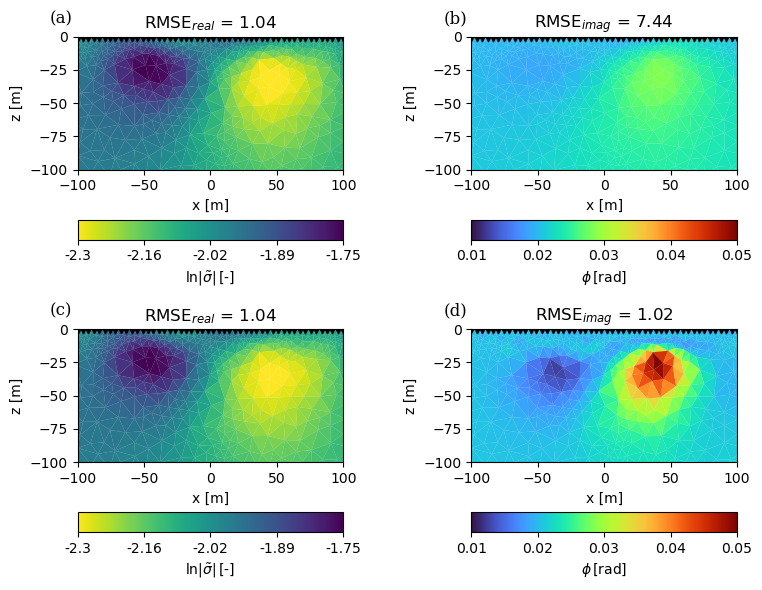

In [20]:
fig, axes = plt.subplot_mosaic([["(a)", "(b)"], ["(c)", "(d)"]], figsize=(8, 6))

ax = axes["(c)"]
ax.set_title(r"RMSE$_{real}$ = " + str(np.round(rmse[1], 2)))
pg.show(ERTinv.paraDomain, (np.real(m_plot)), ax=ax, label=r"$\ln|\tilde{\sigma}|\,$[-]", logScale=0, cMap="viridis_r", cMin=-2.3, cMax=-1.75)

ax = axes["(d)"]
ax.set_title(r"RMSE$_{imag}$ = " + str(np.round(rmse[2], 2)))
pg.show(ERTinv.paraDomain, np.imag(m_plot), ax=ax, label=r"$\phi\,$[rad]", logScale=0, cMap="turbo", cMin=0.01, cMax=0.05)

ax = axes["(a)"]
ax.set_title(r"RMSE$_{real}$ = " + str(np.round(rmse2[1], 2)))
pg.show(ERTinv.paraDomain, (np.real(m_plot2)), ax=ax, label=r"$\ln|\tilde{\sigma}|\,$[-]", logScale=0, cMap="viridis_r", cMin=-2.3, cMax=-1.75)

ax = axes["(b)"]
ax.set_title(r"RMSE$_{imag}$ = " + str(np.round(rmse2[2], 2)))
pg.show(ERTinv.paraDomain, np.imag(m_plot2), ax=ax, label=r"$\phi\,$[rad]", logScale=0, cMap="turbo", cMin=0.01, cMax=0.05)

for iax in axes.keys():
    ax = axes[iax]
    ax.scatter(electrode_positions[:, 0], electrode_positions[:, 1], marker="v", color="k")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("z [m]")
    
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 0)
    
    label = iax
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize='large', va='bottom', fontfamily='serif')

fig.tight_layout()

# fig.savefig("Figure2.pdf", bbox_inches="tight")

In [21]:
# estimation of the variances

Vxx = np.diagonal(ciManager._S_inv @ COV @ ciManager._S)[:ciManager.M].real * 0.5
Vyy = np.diagonal(ciManager._S_inv @ COV @ ciManager._S)[ciManager.M:].real * 0.5

Vxx2 = np.diagonal(ciManager._S_inv @ COV2 @ ciManager._S)[:ciManager.M].real * 0.5
Vyy2 = np.diagonal(ciManager._S_inv @ COV2 @ ciManager._S)[ciManager.M:].real * 0.5

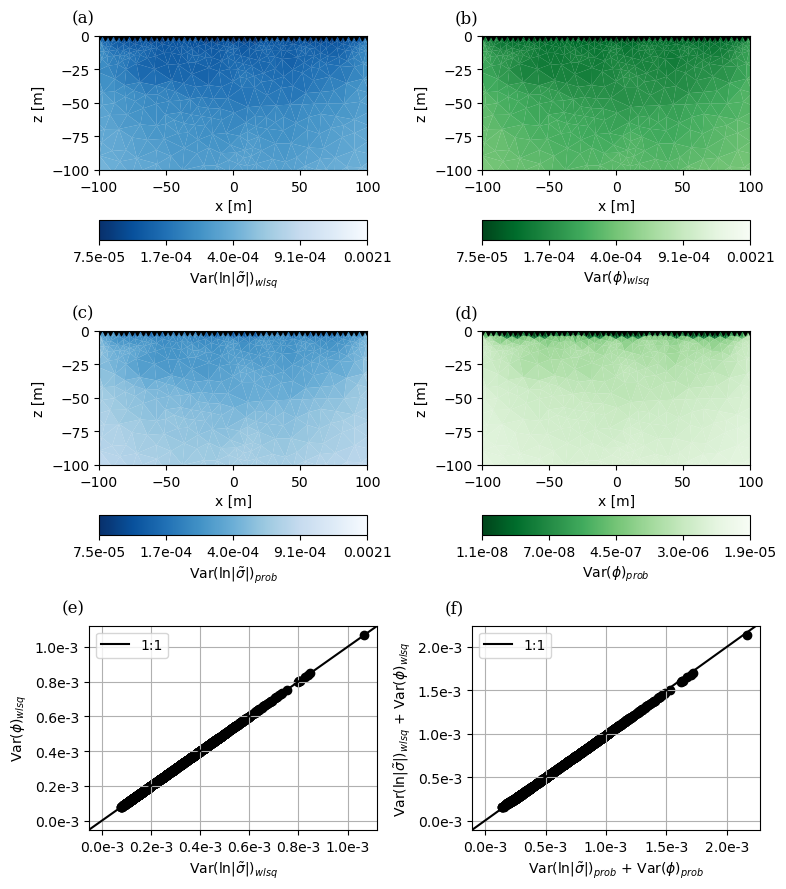

In [22]:
fig, axes = plt.subplot_mosaic([["(a)", "(b)"], ["(c)", "(d)"], ["(e)", "(f)"]], figsize=(8, 9))

ax = axes["(c)"]
pg.show(mesh_inv_inner, Vxx, logScale=1, cMap="Blues_r", ax=ax, label=r"Var$(\ln|\tilde{\sigma}|)_{prob}$", cMin=7.5e-5, cMax=0.0021)

ax = axes["(d)"]
pg.show(mesh_inv_inner, Vyy, logScale=1, cMap="Greens_r", ax=ax, label=r"Var$(\phi)_{prob}$")


ax = axes["(a)"]
pg.show(mesh_inv_inner, Vxx2, logScale=1, cMap="Blues_r", ax=ax, label=r"Var$(\ln|\tilde{\sigma}|)_{wlsq}$", cMin=7.5e-5, cMax=0.0021)


ax = axes["(b)"]
pg.show(mesh_inv_inner, Vyy2, logScale=1, cMap="Greens_r", ax=ax, label=r"Var$(\phi)_{wlsq}$", cMin=7.5e-5, cMax=0.0021)


ax = axes["(e)"]
ax.scatter(Vxx2 * 1e3, Vyy2 * 1e3, color="k")
ax.grid()
ax.axline((0, 0), slope=1, ls="-", color="k", label="1:1")
ax.set_xlabel(r"Var($\ln|\tilde{\sigma}|$)$_{wlsq}$")
ax.set_ylabel(r"Var($\phi$)$_{wlsq}$")
ax.legend(loc=0)
ax.xaxis.set_major_formatter(lambda x, pos: str(np.round(x, 2)) + "e-3") 
ax.yaxis.set_major_formatter(lambda x, pos: str(np.round(x, 2)) + "e-3") 

ax = axes["(f)"]
ax.scatter((Vxx + Vyy) * 1e3, (Vxx2 + Vyy2) * 1e3, color="k")
ax.grid()
ax.axline((0, 0), slope=1, ls="-", color="k", label="1:1")
ax.set_xlabel(r"Var($\ln|\tilde{\sigma}|$)$_{prob}$ + Var($\phi$)$_{prob}$")
ax.set_ylabel(r"Var($\ln|\tilde{\sigma}|$)$_{wlsq}$ + Var($\phi$)$_{wlsq}$")
ax.legend(loc=0)
ax.xaxis.set_major_formatter(lambda x, pos: str(np.round(x, 2)) + "e-3") 
ax.yaxis.set_major_formatter(lambda x, pos: str(np.round(x, 2)) + "e-3") 

for iax in axes.keys():
        
    ax = axes[iax]
    
    if iax not in ("(e)", "(f)"):
    
        ax.scatter(electrode_positions[:, 0], electrode_positions[:, 1], marker="v", color="k")
        ax.set_xlabel("x [m]")
        ax.set_ylabel("z [m]")

        ax.set_xlim(-100, 100)
        ax.set_ylim(-100, 0)
    
    label = iax
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize='large', va='bottom', fontfamily='serif')
    ax.set_title(" ")

fig.tight_layout()

# fig.savefig("Figure3.pdf", bbox_inches="tight")